In [11]:
#HIDDEN 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
#import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

## Bootstrapping for Linear Regression (Inference for the True Coefficients)

Recall that in linear regression, we create a model of the following form
$$
f_\hat{\theta} (x) = \hat{\theta_0} + \hat{\theta_1} x_1 + \ldots + \hat{\theta_p} x_p
$$

We would like to infer the true coefficients of the model. Since the $\hat{\theta_0}$, $\hat{\theta_1}$, $\ldots$ $\hat{\theta_p}$ are estimators that vary based on our training data/observations, we would like to understand how our estimated coefficients compare with the true coefficients. Bootstrapping is a *nonparametric* approach to statistical inference that gives us standard errors and confidence intervals for our parameters. 

Let's take a look at an example of how we use bootstrapping methods within linear regression. 


### The Data

Otis Dudley Duncan was a quantitative sociologist interested in measuring the prestige levels of different occupations. There were only 90 occupations that were rated for their prestige level in the 1947 National Opinion Research Center (NORC) survey. Duncan wanted to “fill in” prestige scores for unrated occupations by using income and education data about each occupation recorded by the 1950 census. When joining the NORC data with the 1950 census data, only 45 occupations could be matched. Ultimately, Duncan's goal was to create a model to explain prestige using different characteristics; using this model, one can predict the prestige of other occupations not recorded in the NORC survey.

The Duncan dataset contains information on the prestige and other characteristics of 45 U. S. occupations in 1950. 
The variables are:

`occupation` represents the type of occupation/title.

`income` represents the percentage of occupational incumbents who earned incomes in excess of $3,500.

`education` represents the percentage of incumbents in the occupation in the 1950 U.S. Census who were high school graduates.

`prestige` represents the percentage of respondents in a survey who rated an occupation as “good” or “excellent” in prestige.






In [24]:
duncan = pd.read_csv('duncan.csv').loc[:, ["occupation", "income", "education", "prestige"]]
duncan

,occupation,type,income,education,prestige
0,accountant,prof,62,86,82
1,pilot,prof,72,76,83
2,architect,prof,75,92,90
...,...,...,...,...,...
42,janitor,bc,7,20,8
43,policeman,bc,34,47,41
44,waiter,bc,8,32,10


It is usually a good idea to explore the data through visualization in order to gain an understanding of the relationships between your variables. Below, we will visualize the correlations between income, educationa and prestige.

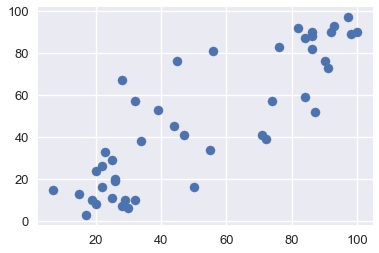

In [5]:
plt.scatter(x=duncan["education"], y=duncan["prestige"])

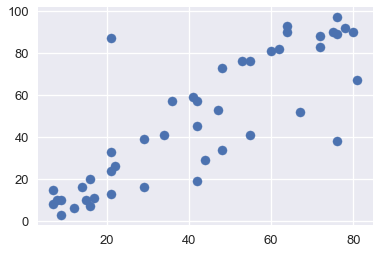

In [6]:
plt.scatter(x=duncan["income"], y=duncan["prestige"])

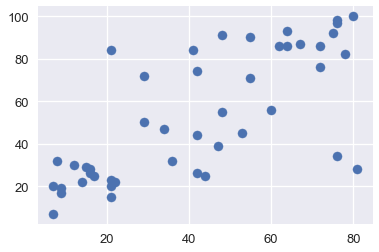

In [7]:
plt.scatter(x=duncan["income"], y=duncan["education"])

From the plots above, we see that both education and income are positively correlated with prestige; hence, both of these variables might be useful in helping explain prestige. Let's fit a linear model using these explanatory variables to explain prestige.

### Fitting the model 

We will create the following model, that explains the prestige of an occupation as a linear function of income and education:

$$
\texttt{prestige}_i
= \theta_0^* 
+ \theta_\texttt{income}^*\cdot\texttt{income}_i
+ \theta_\texttt{education}^*\cdot\texttt{education}_i
+ \varepsilon_i
$$

In order to create this model, we will define the design matrix (X) and our response variable (y):

In [31]:
X = duncan.loc[:, ["income", "education"]]
X.head()

,income,education
0,62,86
1,72,76
2,75,92
3,55,90
4,64,86


In [30]:
y = duncan.loc[:, "prestige"]
y.head()

0    82
1    83
2    90
3    76
4    90
Name: prestige, dtype: int64

Below, we fit our linear model and print all the $\theta$ coefficients of the model (from the equation above) after the model has been fit to the data. Note that these are our observed coefficients.

In [19]:
import sklearn.linear_model as lm

linear_model = lm.LinearRegression()
linear_model.fit(X, y)

print("""
intercept: %.2f
income:    %.2f
education:    %.2f
""" % (tuple([linear_model.intercept_]) + tuple(linear_model.coef_)))


intercept: -6.06
income:    0.60
education:    0.55



The coefficients above give us an estimate of the true coefficients. But had our sample data been different, we would have fit our model to different data, causing these coefficients to be different. We would like to explore what our coefficients might have been using bootstrapping methods.

In our bootstrapping methods and analysis, we will focus on the coefficient of education. We would like to explore the partial relationship between prestige and education holding income constant (rather than the marginal relationship between prestige and education ignoring income). The partial regression coefficient $\widehat\theta_\texttt{education}$ illustrates the partial relationship between prestige and education within our data. 

### Method 1: Bootstrapping the Observations 

In this method, we consider the pairs $(X_i, y_i)$ to be our sample, so we construct the bootstrap resample by sampling with replacement from these pairs:

$$
(X_i^*, y_i^*) 
= (X_I, y_I), \text{ where } I=1,\dots,n \text{ is sampled uniformly at random.}
$$

In other words, we sample n observations with replacement from our data points; this is our bootstrap sample. Then we will fit a new linear regression model to this sampled data and record the education coefficient $\widehat\theta_\texttt{education}$; this coefficient is our bootstrap statistic.

#### Bootstrap Sampling Distribution of $\widehat\theta_\texttt{education}$



In [33]:
def simple_resample(n): 
    return(np.random.randint(low = 0, high = n, size = n))

def bootstrap(boot_pop, statistic, resample = simple_resample, replicates = 10000):
    n = len(boot_pop)
    resample_estimates = np.array([statistic(boot_pop[resample(n)]) for _ in range(replicates)])
    return resample_estimates

In [34]:
def educ_coeff(data_array):
    X = data_array[:, 1:]
    y = data_array[:, 0]
    
    linear_model = lm.LinearRegression()
    model = linear_model.fit(X, y)
    theta_educ = model.coef_[1]

    return theta_educ

data_array = duncan.loc[:, ["prestige", "income", "education"]].values

theta_hat_sampling = bootstrap(data_array, educ_coeff)

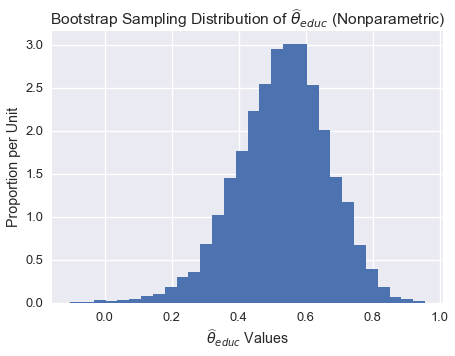

In [39]:
plt.figure(figsize = (7, 5))
plt.hist(theta_hat_sampling, bins = 30, normed = True)
plt.xlabel("$\\widehat{\\theta}_{educ}$ Values")
plt.ylabel("Proportion per Unit")
plt.title("Bootstrap Sampling Distribution of $\\widehat{\\theta}_{educ}$ (Nonparametric)");
plt.show()


#### Estimating the True Coefficients

Although we cannot directly measure $\theta_\texttt{education}$ we can use a bootstrap confidence interval to account for variability in the sample regression coefficient $\widehat\theta_{\texttt{education}}$. Below, We construct an approximate 95% confidence interval for the true coefficient $\widehat\theta_\texttt{education}$, using the bootstrap percentile method. The confidence interval extends from the 2.5th percentile to the 97.5th percentile of the 10,000 bootstrapped coefficients.

In [25]:
left_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 2.5)
right_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 97.5)

left_confidence_interval_endpoint, right_confidence_interval_endpoint

(0.23605055884719855, 0.77537485790998895)

From the confidence interval above, we are fairly certain that the true coefficient lies between 0.236 and 0.775.

#### Could the true coefficient be 0?

Although we observed a positive partial relationship between education and prestige (from the 0.55 coefficient), what if the true coefficient is actually 0 and there is no partial relationship between education and prestige? In this case, the association that we observed was just due to variability in obtaining the points that form our sample.

To formally test whether the partial relationship between education and prestige is real, we would like to test the following hypotheses:

**Null Hypothesis:** The true partial coefficient is 0.

**Alternative Hypothesis.** The true partial coefficient is not 0.

Since we have already contructed a 95% confidence interval for the true coefficient, we just need to see whether 0 lies within this interval. Notice that 0 does not lie within our confidence interval above; therefore, we have enough evidence to reject the null hypothesis.  

If the confidence interval for the true coefficient did contain 0, then we would not have enough evidence to reject the null hypothesis. In this case, the observed coefficient $\widehat\theta_{\texttt{education}}$ would likely spurious.


#### Method 1 Bootstrapping Reflection

In order to build the sampling distribution of the coefficient $\widehat\theta_{\texttt{education}}$ and contruct the confidence interval for the true coefficient, we directly resampled the observations and created new regression models on our bootstrap samples. This method implicitly treats the regressors $X_i$ as random rather than fixed.

In some cases, we may want to treat the $X_i$ as fixed (if, for example, the data were derive from an experimental
design). In the case where the explanatory variables were controlled for, or the values of the explanatory variables were set by the experimenter, then we may consider the following alternative bootstrapping method.

### Method 2: Bootstrapping the Residuals

In this method, we consider the *residuals* $e_i := y_i - X_i\widehat\beta $ to be our sample, so we construct the bootstrap resample by sampling with replacement from these pairs:

$$
(X_i^*, y_i^*) 
= (X_i, X_i\widehat\beta + e_I), \text{ where } I=1,\dots,n \text{ is sampled uniformly at random.}
$$

Once we construct each bootstrap sample, we regress our new Y values onto the fixed X values to obtain bootstrap regression coefficients.

For more clarity, let's break this method down into steps:

1. Estimate the regression coefficients for the original sample, and calculate
the fitted value $\widehat y$ and residual $e_i$ for each observation.

2. Select bootstrap samples of the residuals $e_1, e_2, \dots e_n$ and calculate bootstrapped $y_i^*$ values by computing $\widehat y + e_I$ where the fitted values $\widehat y = X_i\widehat\beta$
are obtained from the original regression. 

3.  Regress the bootstrapped $y_i^*$ values on the fixed X values to obtain bootstrap regression
coefficients $\widehat \theta$.

4. Repeat steps two and three several times in order to obtain several bootstrap regression coefficients $\widehat \theta_1, \widehat \theta_2, \dots \widehat \theta_n$. These can be used to compute bootstrap standard errors and confidence intervals. 

In [40]:
y_hat = linear_model.predict(X)
residuals = (y - y_hat).values

def educ_coeff_semi(e, X = X, y_hat = y_hat):
    y_new = y_hat + e
    
    linear_model = lm.LinearRegression()
    model_new = linear_model.fit(X, y_new)
    return(model_new.coef_[1])

theta_hat_sampling_semi = bootstrap(residuals, educ_coeff_semi)

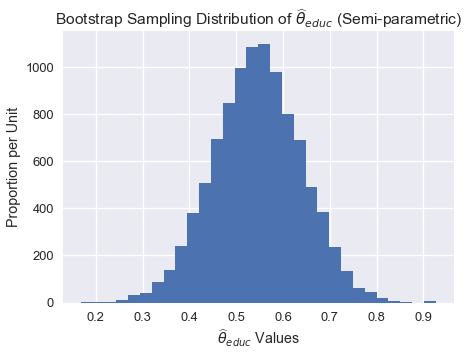

In [42]:
plt.figure(figsize = (7, 5))
plt.hist(theta_hat_sampling_semi, bins = 30)
plt.xlabel("$\\widehat{\\theta}_{educ}$ Values")
plt.ylabel("Proportion per Unit")
plt.title("Bootstrap Sampling Distribution of $\\widehat{\\theta}_{educ}$ (Semi-parametric)");
plt.show()

#### Estimating the True Coefficients

We can construct a confidence interval using the same technique as before.

In [34]:
left_confidence_interval_endpoint_semi = np.percentile(theta_hat_sampling_semi, 2.5)
right_confidence_interval_endpoint_semi = np.percentile(theta_hat_sampling_semi, 97.5)

left_confidence_interval_endpoint_semi, right_confidence_interval_endpoint_semi

(0.36043155555175738, 0.73017873381649079)

Notice this confidence interval is more narrow than the previous one we created. Also, observe that 0 is not in our confidence interval, so we can still be assured that the true coefficient is not 0. 

#### Confidence Interval Using Normal Theory

We can also create confidence intervals based on normal theory. Since the $\widehat \theta_{educ}$ values appear normally distributed, we can construct a confidence interval using by computing the following:

$[\bar x - 1.96 \frac {\sigma}{\sqrt n},  \bar x - 1.96 \frac {\sigma}{\sqrt n}]$

where $\bar x$ is the sample average, $z$ is a constant, $\sigma$ is the sample standard deviation and $n$ is the sample size. Note that $z$ varies depending on the confidence level of the interval we are constructing.

Since we do not know $\sigma$, we can estimate it using our sample standard deviation $s$.

In [44]:
left_confidence_interval_endpoint_normal = np.mean(theta_hat_sampling_semi) - (1.96*(np.std(theta_hat_sampling_semi)/10000))
right_confidence_interval_endpoint_normal = np.mean(theta_hat_sampling_semi) + (1.96*(np.std(theta_hat_sampling_semi)/10000))
left_confidence_interval_endpoint_normal, right_confidence_interval_endpoint_normal


(0.54562566661492085, 0.54566259670256678)

We will not go into this method in great detail, but if you would like to learn more, refer to X.

#### Method 2 Bootstrapping Reflection

Let's reflect on this method. By randomly reattaching resampled residuals to ﬁtted values, this 
procedure implicitly assumes that the errors are identically distributed. More specifically, this method assumes that the distribution of fluctuations around the regression curve is the same for all values of the input x. This is a disadvantage because the true errors may have nonconstant variance; this phenomenon is called heteroscedasticity.

Although this method does not make any assumptions about the shape of the error distribution, it implicitly assumes that the functional form of the model is correct. By relying on the model to create each bootstrap sample, we assume that the model structure is appropriate.



## Summary

In this section, we highlight two different types of bootstrapping techniques used in a linear regression setting. 

In general, method 1 is more commonly used for bootstrapping. This method if often more robust because it makes less assumptions; for example, if an incorrect model is fitted, this method will still yield an appropriate sampling distribution of the parameter of interest.

We use method 2 when we would like the treat X as fixed. Note that this method makes additional assumptions about the errors and form of the model. This method is more efficient if the correct model has been fitted.